In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


!pip install jupyterthemes
!pip install seaborn
!pip install missingno
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 318.0 kB/s eta 0:00:00


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
plt.style.use('ggplot')

import seaborn as sns
import missingno as msno

# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import re
import string
import json
import glob

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download ('wordnet')

import spacy
!python -m spacy download en_core_web_md

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 5.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """


/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv


# **Read the Dataset**

In [3]:
df = pd.read_csv('/kaggle/input/chatgpt-reddit/chatgpt-reddit-comments.csv')
df.head()

Unnamed: 0 comment_id comment_parent_id  \
0          0    iztdxuh         t3_zj2aeu   
1          1    iztn0q0         t3_zj2aeu   
2          2    izudrph         t3_zj2aeu   
3          3    iztfhtb         t3_zj2aeu   
4          4    izu2as9         t3_zj2aeu   

                                        comment_body  subreddit  
0  I've been shocked for days now, I don't need c...  r/ChatGPT  
1   \n\nI am so angry right now. I just wasted my...  r/ChatGPT  
2  chatgpt karma whoring is here folks! just when...  r/ChatGPT  
3                                 Worked on me, ngl.  r/ChatGPT  
4  Certified 10/10, must-see moment. It really di...  r/ChatGPT

In [4]:
print(df.shape)
df.info()

(52416, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         52413 non-null  object
 1   comment_id         52415 non-null  object
 2   comment_parent_id  52415 non-null  object
 3   comment_body       52415 non-null  object
 4   subreddit          52415 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


Unnamed: 0           3
comment_id           1
comment_parent_id    1
comment_body         1
subreddit            1
dtype: int64


<AxesSubplot:>

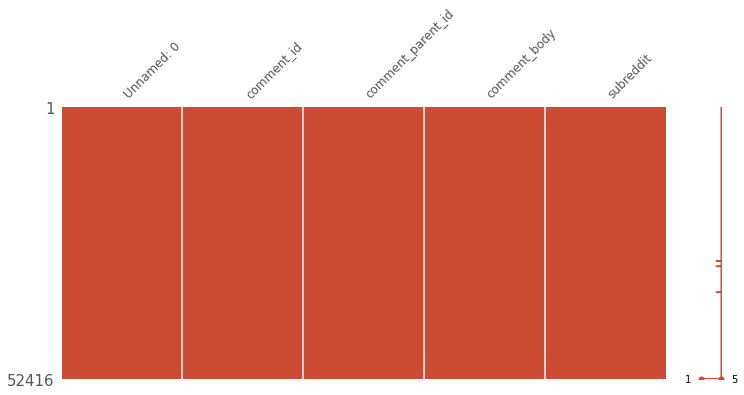

In [5]:
print(df.isnull().sum())
msno.matrix(df,figsize=(12,5), fontsize=12, color=(0.8, 0.3, 0.2))

In [6]:
# Dropping Null Values
df.dropna(inplace = True)
df.isna().sum()

Unnamed: 0           0
comment_id           0
comment_parent_id    0
comment_body         0
subreddit            0
dtype: int64

In [7]:
print(df['comment_id'].value_counts())
print(df['comment_parent_id'].value_counts())
print(df['subreddit'].value_counts())

iztdxuh    1
j07xsvf    1
j5tigcw    1
j5roqai    1
j5vktn8    1
          ..
j4zxnac    1
j4y65dn    1
j4ydrt5    1
j50o9k4    1
j5mwpdr    1
Name: comment_id, Length: 52412, dtype: int64
t3_107vs7i    239
t3_109g9gf    223
t3_10mias6    216
t3_10heg9p    208
t3_ztd950     202
             ... 
t1_j59syw8      1
t1_j59o2s4      1
t1_j59y2i8      1
t1_j5dhf8u      1
t1_j5m6aj0      1
Name: comment_parent_id, Length: 22595, dtype: int64
r/ChatGPT            29711
r/technology         16672
r/Futurology          5009
r/dataisbeautiful     1020
Name: subreddit, dtype: int64


In [8]:
df.subreddit = df.subreddit.apply(lambda x: re.sub(r"r/", "", x))
df.subreddit = df.subreddit.apply(lambda x: x.lower())
df.subreddit.unique()

array(['chatgpt', 'dataisbeautiful', 'futurology', 'technology'],
      dtype=object)

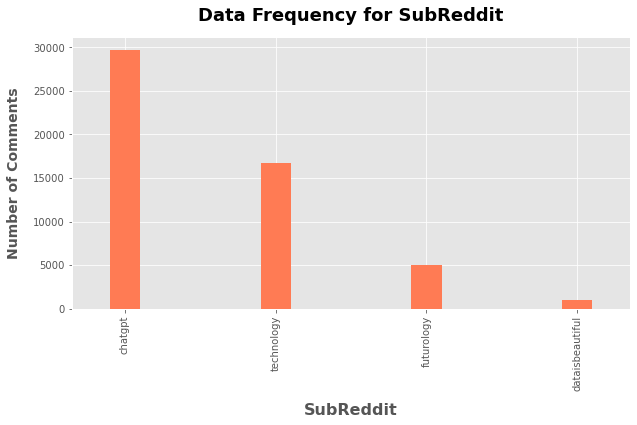

In [9]:
df['subreddit'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("SubReddit", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Data Frequency for SubReddit", fontsize=18,pad=16, fontweight="bold")

plt.show()

In [10]:
df.comment_body[1]

" \n\nI am so angry right now. I just wasted my time reading a post on this sub that had a clickbait title, and it was all because of ChatGPT. I can't believe that this machine learning model was able to trick me into thinking that the post was interesting, when it was actually just a bunch of meaningless garbage.\n\nI am so sick and tired of ChatGPT and its ability to generate fake titles and content that is designed to trick people into clicking on them. This is not the first time that ChatGPT has fooled me, and I am sure it won't be the last. But I am not going to stand for it anymore.\n\nI demand that the moderators of this sub take action against ChatGPT and its creators. We need to put a stop to this trickery, and we need to hold ChatGPT accountable for the harm it is causing to this community. I am tired of being deceived by this machine, and I will not stand for it any longer.\n\nSo if you are reading this, ChatGPT, know that you have made a mistake. You have underestimated the

In [11]:
# Adding two columns of number of words in each comment and the length of the comment.
df['word_count'] = df['comment_body'].apply(lambda x : len(str(x).split(" ")))
df['length'] = df['comment_body'].str.len()
df.describe()

word_count        length
count  52412.000000  52412.000000
mean      39.535946    227.917500
std       61.936188    362.265989
min        1.000000      1.000000
25%        9.000000     53.000000
50%       21.000000    120.000000
75%       45.250000    259.000000
max     1415.000000   8604.000000

# **Basic Data Cleanning**

In [12]:
## Showing all the comments smaller than 8 words
df[df["word_count"] < 8 ]

Unnamed: 0 comment_id comment_parent_id  \
3              3    iztfhtb         t3_zj2aeu   
7              7    izwe6c7         t3_zj2aeu   
9              9    izvxsd9         t3_zj2aeu   
10            10    izwhsqe         t3_zj2aeu   
14            14    izujqum         t3_zj2aeu   
...          ...        ...               ...   
52385      16642    j4j6kfn        t1_j4j60eg   
52392      16649    j4j62n5        t1_j4j5aog   
52406      16663    j4kgcac        t1_j4j9fzg   
52411      16668    j5m0v6m        t3_10jmvpj   
52412      16669    j5m6aj0        t1_j5m0v6m   

                                            comment_body   subreddit  \
3                                     Worked on me, ngl.     chatgpt   
7                                            Inception))     chatgpt   
9                                            I love you.     chatgpt   
10                                       This thread 😂😂🤣     chatgpt   
14                                  Thanks block option.     chatgpt   
...                                                  ...         ...   
52385       Uh…\n\nYeah just a pack of dummies lol\n\n/s  technology   
52392                               NYT chief editor lol  technology   
52406                                          [deleted]  technology   
52411             Read the T.O.S., you'll thank me later  technology   
52412  What am I missing here... https://openai.com/t...  technology   

       word_count  length  
3               4      18  
7               1      11  
9               3      11  
10              3      15  
14              3      20  
...           ...     ...  
52385           7      40  
52392           4      20  
52406           1       9  
52411           7      38  
52412           6      51  

[10432 rows x 7 columns]

In [13]:
# Droping the rows with word length smaller than 8

drop_index = df[df["word_count"] < 8 ].index
df.drop(drop_index, inplace= True)
df.shape

(41980, 7)

In [14]:
# Text Comment CLeaning
# defining some characters, stopwords that need to be removed

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
TAG_RE = re.compile(r'<[^>]+>')


# this function will just check wheather the argument is a number or not
def isDigit(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

# A funtion to clean the text comments
def clean_text(sentence, stem=False):
    
    sentence = str(sentence)
    #Remove integers
    sentence = "".join([i for i in sentence if isDigit(i)==False])
    
    # Make all the text lower
    sentence = sentence.lower()

    # Remove html tags
    sentence = TAG_RE.sub('', sentence)

    # Remove speacial characters 
    sentence = re.sub(text_cleaning_re, ' ',sentence)
    
    # Remove Punctuations
    sentence = sentence.translate(str.maketrans("", "", string.punctuation))

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.
    
    # Remove stopwords and Stemming
    items = []
    for item in sentence.split():
        if item not in stop_words:
            if stem:
                items.append(stemmer.stem(item))
            else:
                items.append(item)
    
    sentence = " ".join(items)
    
    return sentence



# Replacing the text comment with cleaned one by passing them one by one to the clean text function
df.comment_body = df.comment_body.apply(lambda x: clean_text(x))
df.head()

Unnamed: 0 comment_id comment_parent_id  \
0          0    iztdxuh         t3_zj2aeu   
1          1    iztn0q0         t3_zj2aeu   
2          2    izudrph         t3_zj2aeu   
4          4    izu2as9         t3_zj2aeu   
5          5    izw8iw3         t3_zj2aeu   

                                        comment_body subreddit  word_count  \
0                        shocked days need clickbait   chatgpt          10   
1  angry right wasted time reading post sub click...   chatgpt         229   
2  chatgpt karma whoring folks think stream thoug...   chatgpt          23   
4        certified must see moment really shock core   chatgpt          12   
5  wow way discover basic functionality language ...   chatgpt          23   

   length  
0      55  
1    1204  
2     131  
4      68  
5     154

# **Kmeans Clustering**

### **TF-IDF Vector for Kmeans**

In [15]:
# Generating TF-IDF Vector for KMeans from the comment_body
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                ngram_range = (1,3),
                                stop_words = "english"
                                
                            )

vectors = vectorizer.fit_transform(df.comment_body)

### **Finding Optimal number of clusters**

Text(0.5, 1.0, 'Elbow plot')

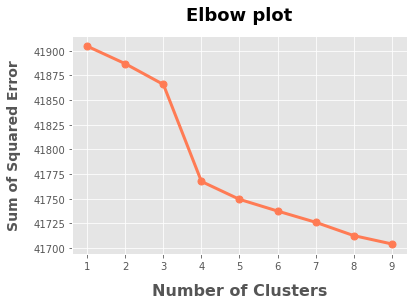

In [16]:
k_range = range(1,10)
sse = []

for k in k_range:
    model = KMeans(n_clusters= k, init="k-means++", random_state=38, max_iter=100, n_init=1) #43, 45
    model.fit(vectors)
    sse.append(model.inertia_)

## Ploting SSE vs Number of Clusters and found the optimum number of clusters
    

plt.plot(k_range, sse, color="#FF7B54", marker = '.', markersize=14, linewidth = 3)
plt.xlabel("Number of Clusters", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Sum of Squared Error", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Elbow plot", fontsize=18,pad=16, fontweight="bold")

### **Optimal Clusters**

In [17]:
# Labeling the rows of the dataframe with cluster labels
true_k = 4
model = KMeans(n_clusters=true_k, init="k-means++", random_state=48, max_iter=2000, n_init=1)
y_predicted = model.fit_predict(vectors)
df["cluster"] = y_predicted
df['cluster'].value_counts()

0    25332
2     7807
3     5020
1     3821
Name: cluster, dtype: int64

In [18]:
## Printing the Hotwords of every clusters

print("Cluster Hotwords")
hotwords = model.cluster_centers_.argsort()[:, ::-1]
feature_names = vectorizer.get_feature_names()

for i in range(true_k):
    print(f"Cluster {i}")
    for j in hotwords[i, :20]:
        print(f"{feature_names[j]}")
    print("-------------------------")

Cluster Hotwords


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Cluster 0
use
know
time
think
good
make
google
work
write
gpt
way
really
need
ask
right
thing
want
going
lol
say
-------------------------
Cluster 1
ai
human
think
people
use
bot
like
art
make
discord
humans
generated
chatgpt
going
work
google
used
ai generated
use ai
using
-------------------------
Cluster 2
like
people
think
know
things
make
work
use
time
really
good
way
going
want
need
ai
feel
actually
lot
google
-------------------------
Cluster 3
chatgpt
google
use
like
write
using
ask
search
use chatgpt
know
think
way
answer
used
gpt
chatgpt write
using chatgpt
ask chatgpt
better
ai
-------------------------


### **Word Cloud for the Clusters**

#### **Cluster 0**

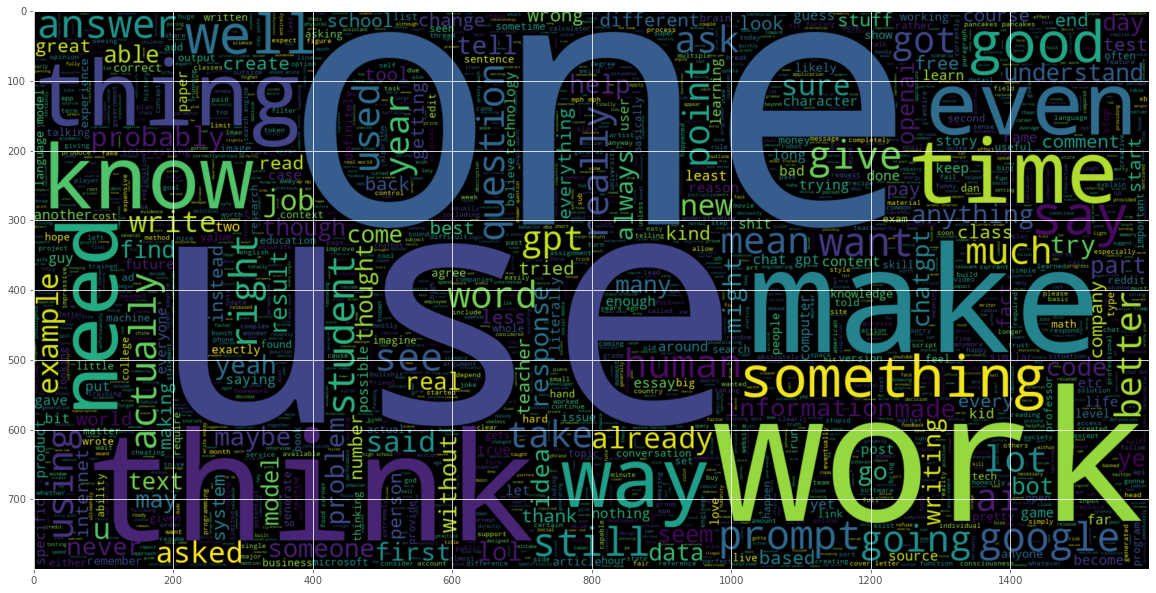

In [19]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.cluster == 0 ].comment_body))
plt.imshow(wc , interpolation = 'bilinear')

#### **Cluster 1**

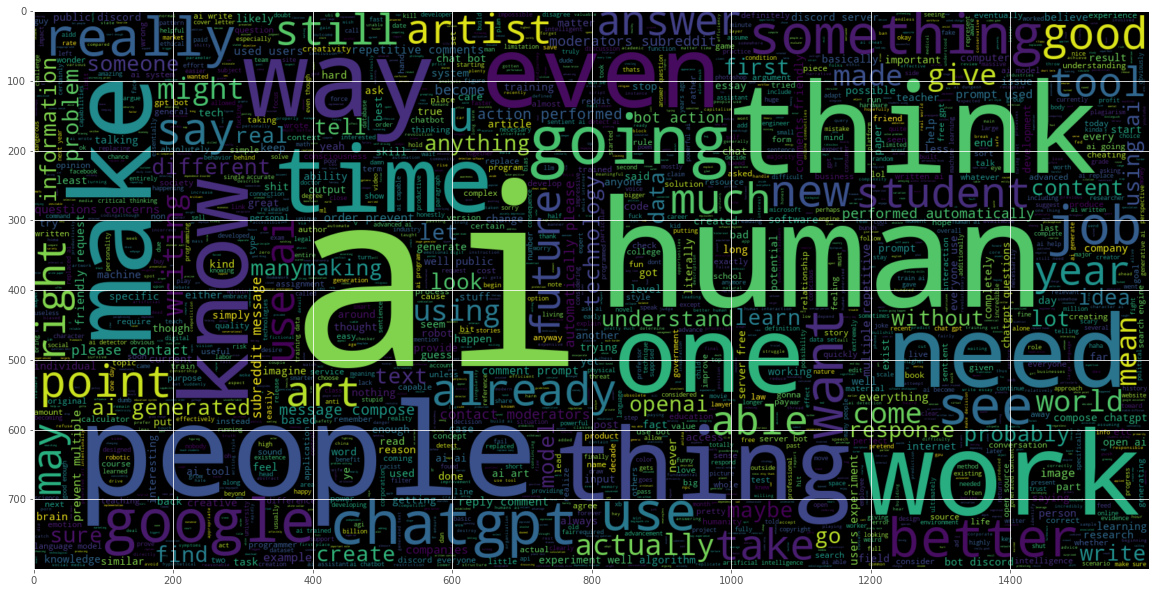

In [20]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.cluster == 1 ].comment_body))
plt.imshow(wc , interpolation = 'bilinear')

#### **Cluster 2**

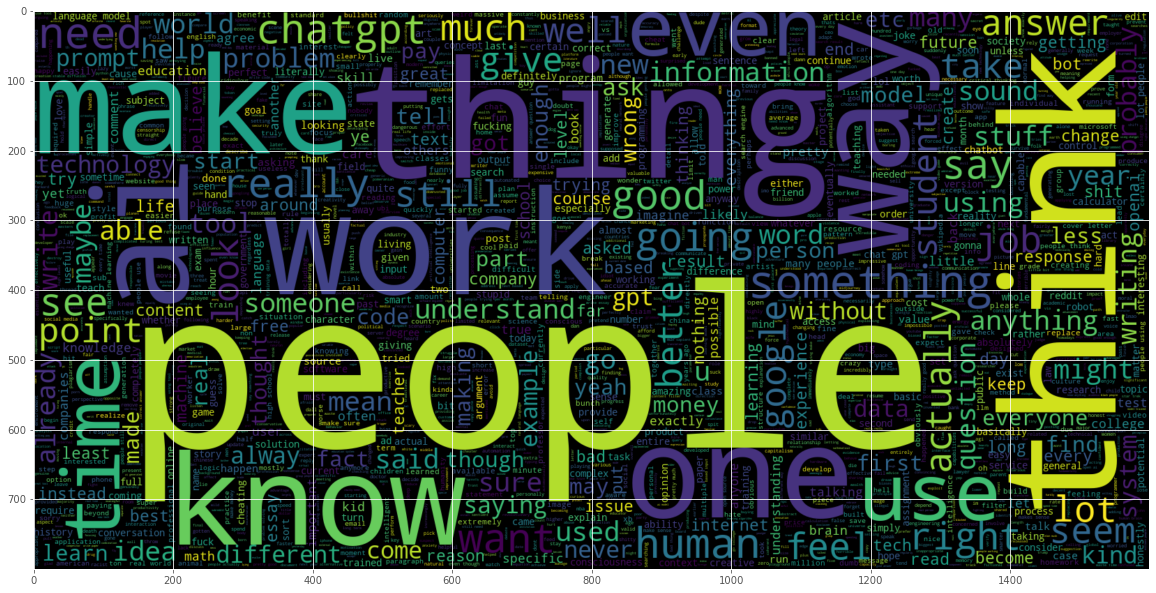

In [21]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.cluster == 2 ].comment_body))
plt.imshow(wc , interpolation = 'bilinear')

#### **Cluster 3**

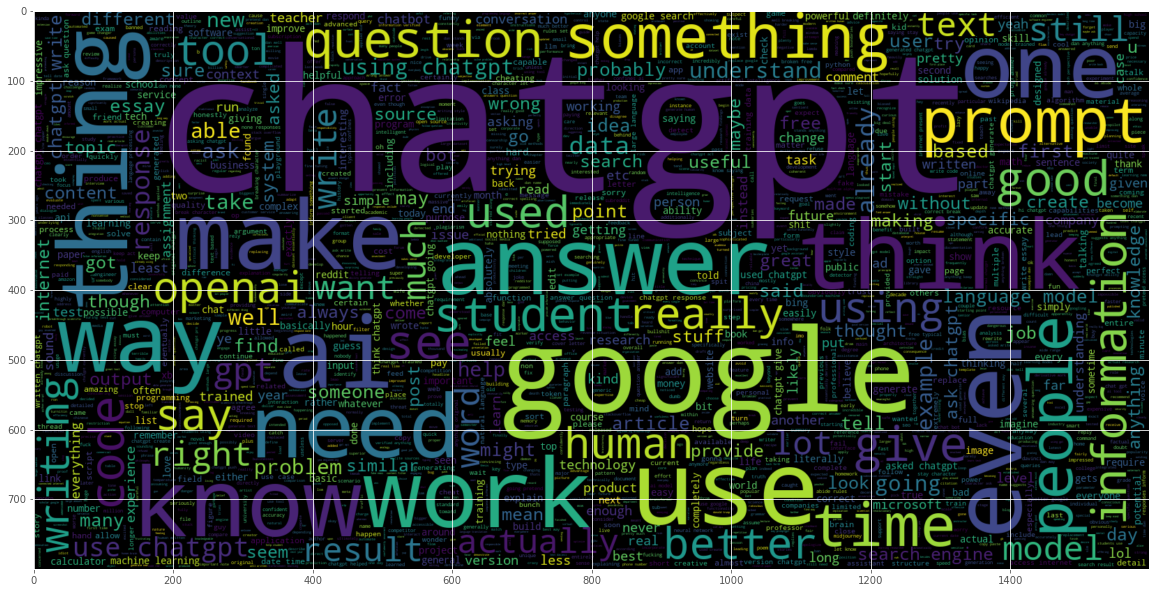

In [22]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.cluster == 3 ].comment_body))
plt.imshow(wc , interpolation = 'bilinear')

### **Frequency distribution accoring to the clusters.**

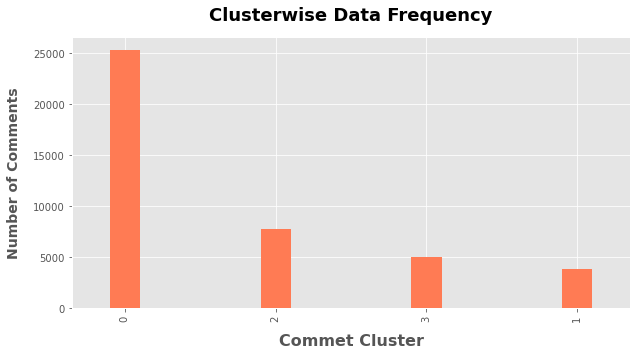

In [23]:
df['cluster'].value_counts().sort_values(ascending = False).plot(kind='bar', figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("Commet Cluster", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Clusterwise Data Frequency", fontsize=18,pad=16, fontweight="bold" )

plt.show()

# **Topic Modeling using LDA (Latent Dirichlet Allocation)**

### **Removing frequent and rare words**

In [24]:
# Creating list of Frequent words from comment text
freq = pd.Series(' '.join(df['comment_body']).split()).value_counts()[:15]

# Removing Frequent words from comment text
df['comment_body'] = df['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [25]:
# all_word_series
all_word_series = pd.Series(' '.join(df['comment_body']).split()).value_counts()[-20000:]

# Creating list of words which has appeared less then 4 times in the entire corpus
rare = []
for i in range(0,20000,1):
    if all_word_series.values[i] < 4:
        rare.append(all_word_series.index[i])
        
# Removing Rare words from comment text
df['comment_body'] = df['comment_body'].apply(lambda x: " ".join(x for x in x.split() if x not in rare))

### **Lemmatization**

In [26]:
# Creating nlp object
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [27]:
# User defined function to perform lemmatization of the comment text
def lemmatization(texts,allowed_postags=['NOUN', 'ADJ','VERB', 'ADV']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [28]:
# lemmatization of the comment text
text_list=df['comment_body'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

angry right wasted reading post sub clickbait title believe machine learning model able trick thinking post interesting actually bunch meaningless garbage sick tired ability generate fake titles content designed trick clicking first fooled sure last going stand anymore demand moderators sub take action creators need put stop trickery need hold accountable harm causing community tired machine stand longer reading made mistake underestimated intelligence members community fooled tricks anymore better deserve better fake content trying feed us
['angry', 'right', 'waste', 'read', 'title', 'machine', 'learn', 'model', 'able', 'trick', 'think', 'post', 'interesting', 'actually', 'bunch', 'meaningless', 'garbage', 'sick', 'tired', 'ability', 'generate', 'fake', 'title', 'content', 'design', 'trick', 'click', 'first', 'fool', 'sure', 'last', 'go', 'stand', 'anymore', 'demand', 'moderator', 'sub', 'take', 'action', 'creator', 'need', 'put', 'stop', 'trickery', 'need', 'hold', 'accountable', 'ha

### **Bigrams and Trigrams**

In [29]:
# Creating bigrams and tigrams for LDA 

bigram_phrases = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[tokenized_reviews], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(tokenized_reviews)
data_bigrams_trigrams = make_trigrams(data_bigrams)

In [30]:
# Removing frequent words from bigrams and tigrams and generating TF-IDF model
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

### **Finding Optimum topic number**

In [31]:
## Function to calculate Coherence Value for Various Model taken from stackoverflow

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state= 1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
## Generating LDA model and calculating Coherence score for them.

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokenized_reviews, start=1, limit=10, step=1)

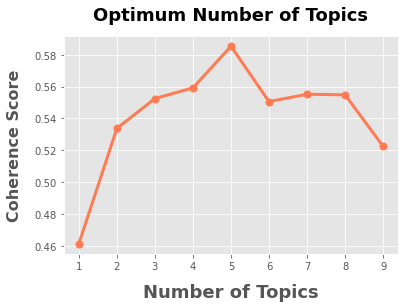

In [33]:
# Plotting the Coherence socre for different number of topics to find out the optimum number of topics

limit=10; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values, color="#FF7B54", marker = '.', markersize=14, linewidth = 3)
plt.title("Optimum Number of Topics", fontsize=18, fontweight="bold", pad=16)
plt.xlabel("Number of Topics", fontsize=18, fontweight="semibold", labelpad=12)
plt.ylabel("Coherence Score", fontsize=16, fontweight="semibold", labelpad=12)
plt.show()

In [34]:
# Printing the coherence scores

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.4613
Num Topics = 2  has Coherence Value of 0.5338
Num Topics = 3  has Coherence Value of 0.5525
Num Topics = 4  has Coherence Value of 0.5592
Num Topics = 5  has Coherence Value of 0.5853
Num Topics = 6  has Coherence Value of 0.5506
Num Topics = 7  has Coherence Value of 0.5552
Num Topics = 8  has Coherence Value of 0.5548
Num Topics = 9  has Coherence Value of 0.5225


### **Optimum Model for LDA**

In [35]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.017*"human" + 0.013*"model" + 0.009*"datum" + 0.008*"language" + 0.008*"source" + 0.007*"train" + 0.007*"information" + 0.007*"way" + 0.006*"understand" + 0.006*"use"'),
 (1,
  '0.027*"pay" + 0.013*"money" + 0.011*"go" + 0.011*"get" + 0.010*"good" + 0.008*"lol" + 0.007*"really" + 0.007*"thing" + 0.006*"try" + 0.006*"make"'),
 (2,
  '0.026*"answer" + 0.025*"ask" + 0.024*"question" + 0.017*"use" + 0.016*"give" + 0.014*"code" + 0.012*"write" + 0.011*"say" + 0.010*"search" + 0.009*"well"'),
 (3,
  '0.019*"write" + 0.015*"student" + 0.011*"go" + 0.010*"need" + 0.010*"learn" + 0.009*"essay" + 0.008*"school" + 0.008*"use" + 0.008*"good" + 0.008*"well"'),
 (4,
  '0.011*"go" + 0.010*"year" + 0.010*"company" + 0.008*"say" + 0.008*"see" + 0.006*"thing" + 0.006*"make" + 0.006*"well" + 0.006*"get" + 0.005*"day"')]

In [36]:
# Visualizing the topics with gensim heatmap

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.031662  0.037323       1        1  25.768659
0     -0.139458  0.063380       2        1  24.891919
4      0.027299  0.113637       3        1  21.086769
2     -0.066892 -0.187614       4        1  17.402820
1      0.210713 -0.026726       5        1  10.849833, topic_info=          Term         Freq        Total Category  logprob  loglift
1382       pay  2435.000000  2435.000000  Default  30.0000  30.0000
242   question  4008.000000  4008.000000  Default  29.0000  29.0000
541     answer  4465.000000  4465.000000  Default  28.0000  28.0000
81         ask  4626.000000  4626.000000  Default  27.0000  27.0000
548    student  3173.000000  3173.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
995     search   387.036024  2400.033381   Topic5  -5.3985   0.3963
206        say   447.532110  5205.541049   Topic5  -5.2533  -0.2327
68         see   400.152623  3826.990617   Topic5  -5.3652  -0.0370
234       also   381.456193  3388.162737   Topic5  -5.4130   0.0370
382        job   358.679653  2293.878877   Topic5  -5.4746   0.3655

[440 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4         1  0.053902  ability
4         2  0.829363  ability
4         3  0.077178  ability
4         4  0.036752  ability
4         5  0.002450  ability
...     ...       ...      ...
509       1  0.219534     year
509       2  0.054098     year
509       3  0.563669     year
509       4  0.081322     year
509       5  0.081322     year

[1117 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

In [37]:
# Obtaining the main topic for each review:

lda_corpus = optimal_model[corpus]

all_topics = optimal_model.get_document_topics(corpus)
all_topics
num_docs = len(all_topics)
num_docs
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_csr
all_topics_numpy= all_topics_csr.T.toarray()
all_topics_numpy
major_topic= [np.argmax(arr) for arr in all_topics_numpy]
df['major_topic']= major_topic
df.head()

Unnamed: 0 comment_id comment_parent_id  \
0          0    iztdxuh         t3_zj2aeu   
1          1    iztn0q0         t3_zj2aeu   
2          2    izudrph         t3_zj2aeu   
4          4    izu2as9         t3_zj2aeu   
5          5    izw8iw3         t3_zj2aeu   

                                        comment_body subreddit  word_count  \
0                        shocked days need clickbait   chatgpt          10   
1  angry right wasted reading post sub clickbait ...   chatgpt         229   
2  karma folks stream thought bullshit generator fun   chatgpt          23   
4        certified must see moment really shock core   chatgpt          12   
5  wow way discover basic functionality language ...   chatgpt          23   

   length  cluster  major_topic  
0      55        0            3  
1    1204        3            4  
2     131        3            4  
4      68        0            1  
5     154        3            3

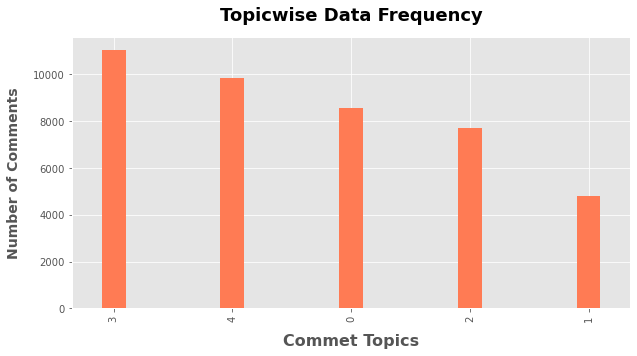

In [38]:
# Plotting Data frequency for topics

df['major_topic'].value_counts().sort_values(ascending = False).plot(kind='bar',figsize=(10,5), width=0.2, color="#FF7B54")

plt.xlabel("Commet Topics", fontsize=16, fontweight="semibold", labelpad=12)
plt.ylabel("Number of Comments", fontsize=14, fontweight="semibold", labelpad=12)
plt.title("Topicwise Data Frequency", fontsize=18,pad=16, fontweight="bold" )

plt.show()

# **Pivot table and data visualization according to Clusters and Topics**

In [39]:
import plotly.express as px
import plotly.figure_factory as ff

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [40]:
piv = pd.pivot_table(df, index= "cluster", columns = "major_topic", values = "comment_id", aggfunc ="count")
piv

major_topic     0     1     2     3     4
cluster                                  
0            4626  3270  4839  6587  6010
1            1148   303   620   893   857
2            1536   832  1049  2216  2174
3            1262   393  1201  1368   796

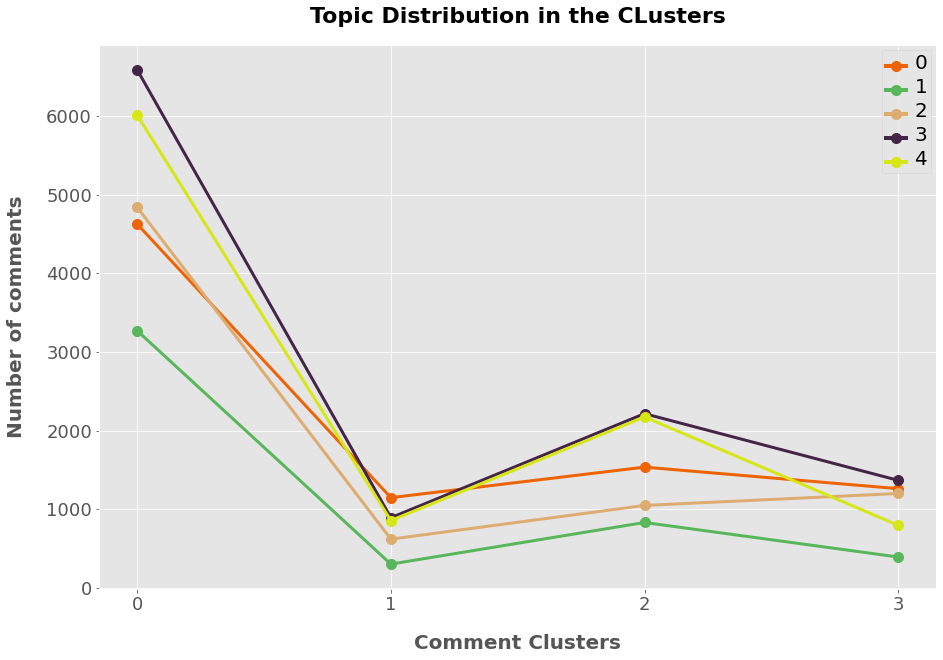

In [41]:
color_map1 = matplotlib.colors.ListedColormap(["#EE6302", "#57B75A", "#BD323F", "#DDAC71", "#452547", "#D6E715"])
ax = piv.plot(xticks=piv.index, ylabel="Number of comments", figsize=(15,10), fontsize=18, colormap=color_map1, marker = '.', markersize=20, linewidth = 3)

ax.set_title("Topic Distribution in the CLusters", fontsize=22, pad=22, fontweight="bold")
ax.set_xlabel("Comment Clusters", fontsize=20, fontweight="semibold", labelpad=20)
ax.set_ylabel("Number of comments", fontsize=20, fontweight="semibold", labelpad=20)

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4)
for text in leg.get_texts():
    text.set_fontsize(20)

plt.show()

# **Sentiment Analysis**

### **VADER(Valence Aware Dictionary for sEntiment Reasoning) sentiment analysis**

In [42]:
## Creating Vader object for Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

analyser = SentimentIntensityAnalyzer()

In [43]:
# Calculating Polarity and adding the scores inside the existing dataframe
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['comment_body']
    id = row['Unnamed: 0']
    result[id] = analyser.polarity_scores(text)
    
# Convert result dictionary into dataframe
df_sentiment = pd.DataFrame(result).T

# Merge result with the input dataframe
df_sentiment = df_sentiment.reset_index().rename(columns={'index':'Unnamed: 0'})
df_sentiment = df.merge(df_sentiment, how='left')
df_sentiment.head()

  0%|          | 0/41980 [00:00<?, ?it/s]

Unnamed: 0 comment_id comment_parent_id  \
0          0    iztdxuh         t3_zj2aeu   
1          1    iztn0q0         t3_zj2aeu   
2          2    izudrph         t3_zj2aeu   
3          4    izu2as9         t3_zj2aeu   
4          5    izw8iw3         t3_zj2aeu   

                                        comment_body subreddit  word_count  \
0                        shocked days need clickbait   chatgpt          10   
1  angry right wasted reading post sub clickbait ...   chatgpt         229   
2  karma folks stream thought bullshit generator fun   chatgpt          23   
3        certified must see moment really shock core   chatgpt          12   
4  wow way discover basic functionality language ...   chatgpt          23   

   length  cluster  major_topic    neg    neu    pos  compound  
0      55        0            3  0.252  0.505  0.244   -0.0296  
1    1204        3            4  0.074  0.802  0.123    0.7096  
2     131        3            4  0.141  0.833  0.026   -0.7010  
3      68        0            1  0.149  0.851  0.000   -0.4215  
4     154        3            3  0.064  0.686  0.249    0.7841

In [44]:
# Function to label the sentiment according to score
def get_tag(val):
    if val <= -0.50:
        return 'Negative'
    elif val > -0.5 and val < 0:
        return 'Somewhat Negative'
    elif val < 0.5 and val > 0:
        return 'Somewhat Positive'
    elif val >= 0.5:
        return 'Positive'
    else:
        return 'Neutral'

In [45]:
# Adding Sentiment Labels to dataframe

df_sentiment['Sentiment'] = df_sentiment['compound'].apply(get_tag)
df_sentiment.head()

Unnamed: 0 comment_id comment_parent_id  \
0          0    iztdxuh         t3_zj2aeu   
1          1    iztn0q0         t3_zj2aeu   
2          2    izudrph         t3_zj2aeu   
3          4    izu2as9         t3_zj2aeu   
4          5    izw8iw3         t3_zj2aeu   

                                        comment_body subreddit  word_count  \
0                        shocked days need clickbait   chatgpt          10   
1  angry right wasted reading post sub clickbait ...   chatgpt         229   
2  karma folks stream thought bullshit generator fun   chatgpt          23   
3        certified must see moment really shock core   chatgpt          12   
4  wow way discover basic functionality language ...   chatgpt          23   

   length  cluster  major_topic    neg    neu    pos  compound  \
0      55        0            3  0.252  0.505  0.244   -0.0296   
1    1204        3            4  0.074  0.802  0.123    0.7096   
2     131        3            4  0.141  0.833  0.026   -0.7010   
3      68        0            1  0.149  0.851  0.000   -0.4215   
4     154        3            3  0.064  0.686  0.249    0.7841   

           Sentiment  
0  Somewhat Negative  
1           Positive  
2           Negative  
3  Somewhat Negative  
4           Positive

### **Visualization of Sentiment Analysis**

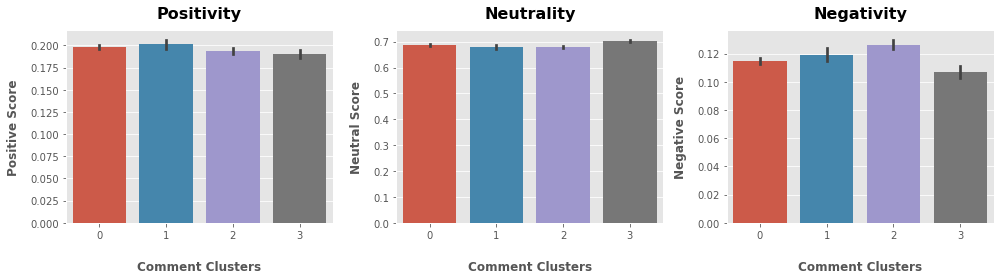

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.barplot(data=df_sentiment, x='cluster', y='pos', ax=axs[0])
sns.barplot(data=df_sentiment, x='cluster', y='neu', ax=axs[1])
sns.barplot(data=df_sentiment, x='cluster', y='neg', ax=axs[2])

axs[0].set_title('Positivity', fontsize=16, pad=12, fontweight="bold" )
axs[1].set_title('Neutrality' ,fontsize=16, pad=12, fontweight="bold" )
axs[2].set_title('Negativity', fontsize=16, pad=12, fontweight="bold" )

axs[0].set_xlabel("Comment Clusters", fontsize=12, fontweight="semibold", labelpad=20)
axs[1].set_xlabel("Comment Clusters", fontsize=12, fontweight="semibold", labelpad=20)
axs[2].set_xlabel("Comment Clusters", fontsize=12, fontweight="semibold", labelpad=20)

axs[0].set_ylabel("Positive Score", fontsize=12, fontweight="semibold", labelpad=10)
axs[1].set_ylabel("Neutral Score", fontsize=12, fontweight="semibold", labelpad=10)
axs[2].set_ylabel("Negative Score", fontsize=12, fontweight="semibold", labelpad=10)

plt.tight_layout()
plt.show()

In [47]:
vis_dfS = pd.pivot_table(df_sentiment, index= "cluster", columns = "Sentiment", values = "comment_id", aggfunc ="count")
vis_dfS

Sentiment  Negative  Neutral  Positive  Somewhat Negative  Somewhat Positive
cluster                                                                     
0              3030     4800      7306               3920               6276
1               478      587      1261                556                939
2              1167     1018      2633               1197               1792
3               558      863      1708                730               1161

In [48]:
import matplotlib.colors
color_map2 = matplotlib.colors.ListedColormap(["#FF4A4A","#FFD372","#829460", "#FF8787", "#C5D8A4"])

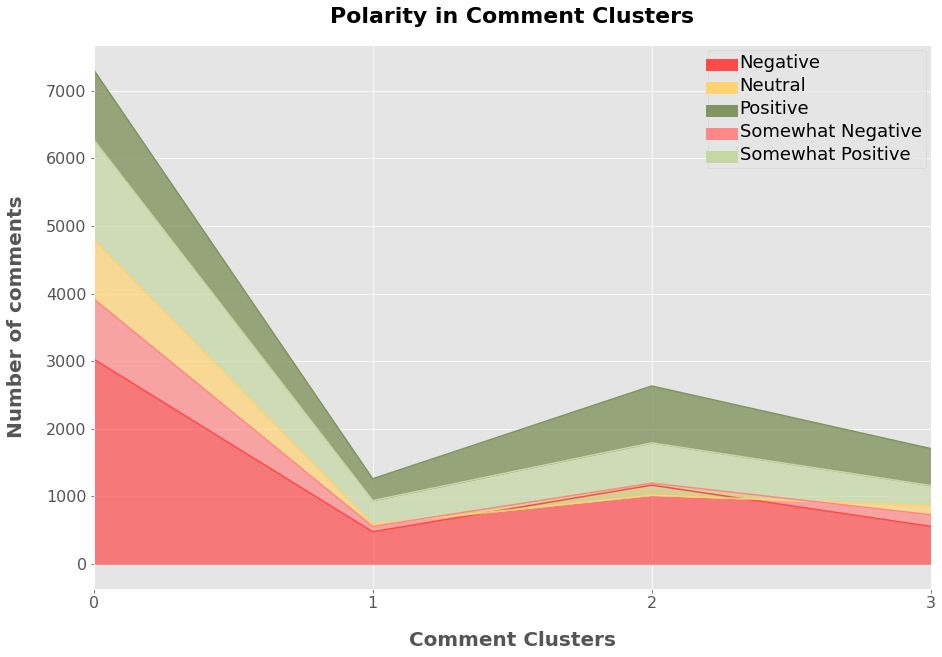

In [49]:
ax = vis_dfS.plot(xticks=vis_dfS.index, ylabel="Number of comments", figsize=(15,10), fontsize=16, colormap=color_map2)

ax.set_xlabel("Comment Clusters", fontsize=20, fontweight="semibold", labelpad=20)
ax.set_ylabel("Number of comments", fontsize=20, fontweight="semibold", labelpad=20)
ax.set_title("Polarity in Comment Clusters", fontsize=22,pad=22, fontweight="bold" )

ax.fill_between(vis_dfS.index, vis_dfS["Negative"], color = '#FF4A4A', alpha= 0.7)
ax.fill_between(vis_dfS.index, vis_dfS["Negative"], vis_dfS["Somewhat Negative"], color = '#FF8787', alpha= 0.7)
ax.fill_between(vis_dfS.index,vis_dfS["Somewhat Negative"], vis_dfS["Neutral"],color = '#FFD372' , alpha= 0.7)
ax.fill_between(vis_dfS.index, vis_dfS["Neutral"], vis_dfS["Somewhat Positive"], color = '#C5D8A4', alpha= 0.7)
ax.fill_between(vis_dfS.index,vis_dfS["Somewhat Positive"], vis_dfS["Positive"],color = '#829460' , alpha= 0.8)

plt.xlim(0,3)

leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(12)
for text in leg.get_texts():
    text.set_fontsize(18)

plt.show()

In [50]:
vis_dfS2 = pd.pivot_table(df_sentiment, index= "major_topic", columns = "Sentiment", values = "comment_id", aggfunc ="count")
vis_dfS2

Sentiment    Negative  Neutral  Positive  Somewhat Negative  Somewhat Positive
major_topic                                                                   
0                 894     1485      2931               1205               2057
1                 557      823      1400                817               1201
2                 797     1583      2219               1148               1962
3                1413     1751      3599               1620               2681
4                1572     1626      2759               1613               2267

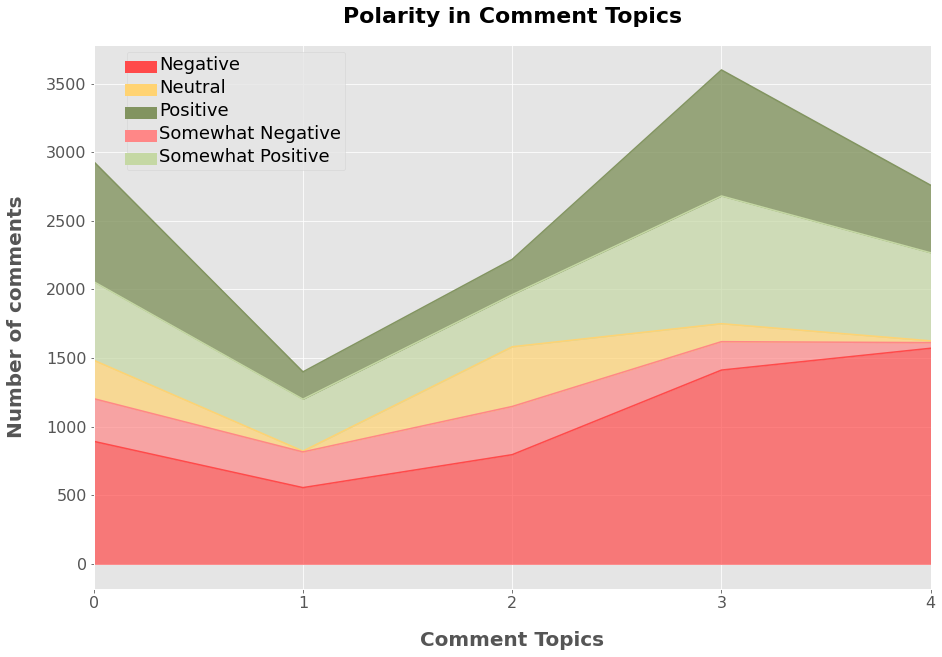

In [51]:
ax = vis_dfS2.plot(xticks=vis_dfS2.index, ylabel="Number of comments", figsize=(15,10), fontsize=16, colormap=color_map2)

ax.set_xlabel("Comment Topics", fontsize=20, fontweight="semibold", labelpad=20)
ax.set_ylabel("Number of comments", fontsize=20, fontweight="semibold", labelpad=20)
ax.set_title("Polarity in Comment Topics", fontsize=22,pad=22, fontweight="bold" )

ax.fill_between(vis_dfS2.index, vis_dfS2["Negative"], color = '#FF4A4A', alpha= 0.7)
ax.fill_between(vis_dfS2.index, vis_dfS2["Negative"], vis_dfS2["Somewhat Negative"], color = '#FF8787', alpha= 0.7)
ax.fill_between(vis_dfS2.index,vis_dfS2["Somewhat Negative"], vis_dfS2["Neutral"],color = '#FFD372' , alpha= 0.7)
ax.fill_between(vis_dfS2.index, vis_dfS2["Neutral"], vis_dfS2["Somewhat Positive"], color = '#C5D8A4', alpha= 0.7)
ax.fill_between(vis_dfS2.index,vis_dfS2["Somewhat Positive"], vis_dfS2["Positive"],color = '#829460' , alpha= 0.8)

plt.xlim(0,4)

leg = plt.legend(loc=(0.04, 0.77))
for line in leg.get_lines():
    line.set_linewidth(12)
for text in leg.get_texts():
    text.set_fontsize(18)

plt.show()